# COVID-19 World Vaccination Progress

*Daniil Valyano*
*03/10/2021*
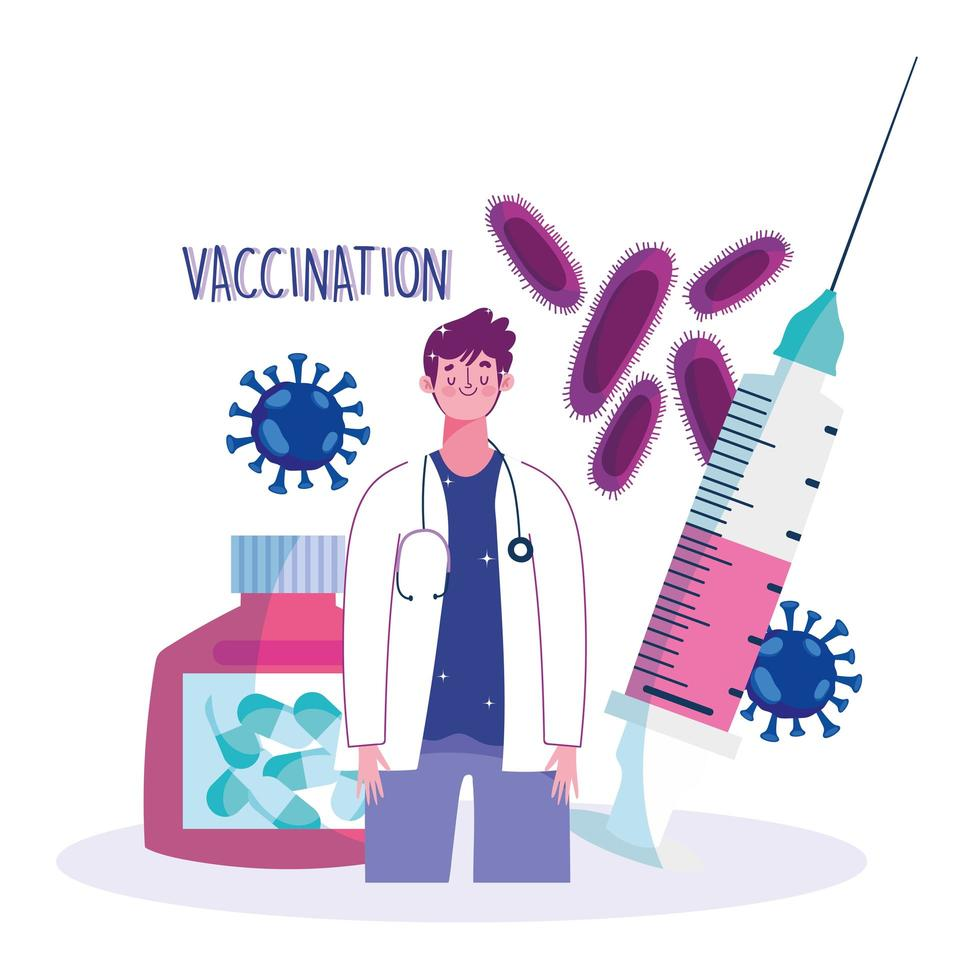

# Acknowledgement
This notebook is a submission for a task of a [COVID-19 World Vaccination Progress]('https://www.kaggle.com/gpreda/covid-world-vaccination-progress') dataset, offered by Gabriel Preda [@gpreda]('https://www.kaggle.com/gpreda')

If you like my job or the methods I used to do it, please **upvote and leave your suggestions in comments!**

# Information

## The initial dataset contains the following features:
* Country- this is the country for which the vaccination information is provided;
* Country ISO Code - ISO code for the country;
* Date - date for the data entry; for some of the dates we have only the daily vaccinations, for others, only the (cumulative) total;
* Total number of vaccinations - this is the absolute number of total immunizations in the country;
* Total number of people vaccinated - a person, depending on the immunization scheme, will receive one or more (typically 2) vaccines; at a certain moment, the number of vaccination might be larger than the number of people;
* Total number of people fully vaccinated - this is the number of people that received the entire set of immunization according to the immunization scheme (typically 2); at a certain moment in time, there might be a certain number of people that received one vaccine and another number (smaller) of people that received all vaccines in the scheme;
* Daily vaccinations (raw) - for a certain data entry, the number of vaccination for that date/country;
* Daily vaccinations - for a certain data entry, the number of vaccination for that date/country;
* Total vaccinations per hundred - ratio (in percent) between vaccination number and total population up to the date in the country;
* Total number of people vaccinated per hundred - ratio (in percent) between population immunized and total population up to the date in the country;
* Total number of people fully vaccinated per hundred - ratio (in percent) between population fully immunized and total population up to the date in the country;
* Number of vaccinations per day - number of daily vaccination for that day and country;
* Daily vaccinations per million - ratio (in ppm) between vaccination number and total population for the current date in the country;
* Vaccines used in the country - total number of vaccines used in the country (up to date);
* Source name - source of the information (national authority, international organization, local organization etc.);
* Source website - website of the source of information;

## Packages used

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns 
import folium

# Statistics 
import scipy
import statsmodels as sms
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

### Loading data

Read the initial dataset with the *Pandas* package, and display the first five rows of it.

In [ ]:
vaccinations = pd.read_csv('../input/covid-world-vaccination-progress/country_vaccinations.csv')
vaccinations.head()

# Data Cleaning
There are few steps in this section:
* As shown by *.head()* method, our data obviously contains missing values, so we'll need to dela with it somehow
* Some of the country names appeared in the dataset, does not represent a single country (constituent countries)
* ***date*** feature refers to a unique moment in time, so needs to be converted into a *Pandas date format* 

In [ ]:
vaccinations["date"] = pd.to_datetime(vaccinations["date"], format = '%Y-%m-%d')
vaccinations = vaccinations.replace([np.inf, -np.inf], np.nan)
vaccinations = vaccinations.fillna(0)

## Normalizing country names

There is still a reason not to start the analysis: unused country names. The United Kingdom of Great Britain and Northern Ireland (UK), since 1922, comprises four constituent countries: England, Scotland, and Wales (which collectively make up Great Britain), as well as Northern Ireland. To fix this, we won´t include England, Scotland, Wales, and Nothern Ireland in our analysis, their data is already stored in the United Kingdom observation.

I also consider to eliminate Gibraltar, Isle of Man, Cayman Islands, Falkland Islands, Guernsey, Saint Helena, Turks and Caicos Islands (UK pertinence), Faeroe Islands (Denmark pertinence). 

In [ ]:
vaccinations.country.unique()

In [ ]:
vaccinations = vaccinations[vaccinations.country.apply(lambda x : x not in ['Scotland', 'Wales', 'Northern Ireland', 'England', 'Isle of Man', 'Cayman Islands', 'Falkland Islands', 'Guernsey', 'Saint Helena', 'Turks and Caicos Islands', 'Faeroe Islands', 'Gibraltar'])]
vaccinations.country.unique()

# EDA

## Vaccination progress track. What type of vaccines is used around the globe?

First of all, we will track the vaccination process by each vaccine, grouped by countries this combination of vaccines is used in, and sorted by *total_vaccinations*. For this, we'll need to know all the unique values the feature *vaccines* may take.

In [ ]:
vaccinations.vaccines.unique()

Define *latest_data* as a DataFrame, which contains the same features, that the initial dataset, but using the latest vaccination data in each country.

In [ ]:
columns = ['country', 'date', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','people_fully_vaccinated_per_hundred','vaccines','iso_code']
latest_data = vaccinations[columns].groupby('country', as_index = True).max().sort_values(by='total_vaccinations', ascending = False)
latest_data.head()

## Which combination of vaccines is used the most? 

The initial dataset *vaccines* feature only contains a combination of many types of vaccines, so that, it's impossible to determine the number of vaccinations by each vaccine individually.

In [ ]:
total_vaccines = pd.DataFrame()
vaccines = vaccinations.groupby('vaccines')
for col, group in vaccines:
    total_vaccines.loc[col,"total_vaccinations"] = group["daily_vaccinations"].sum()
total_vaccines = total_vaccines.sort_values(by='total_vaccinations', ascending = False)

In [ ]:
def show_values_on_bars(axs, h_v="v", space=0.7):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = '{:.0f}%'.format(int(p.get_height()))
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() / 2
                value = '{:.1f}m'.format(int(p.get_width()) / 1000000)
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [ ]:
sns.set_style('darkgrid')
ax = sns.barplot(x = total_vaccines.iloc[:7,:]['total_vaccinations'] , y =total_vaccines.iloc[:7,:].index, palette="rocket")
ax.set_xlabel('Millions of vaccinations')
ax.set_ylabel('Vaccine type')
ax.set_title('Most popular vaccines')
plt.xticks(ticks = [0,10000000,20000000,30000000,40000000,50000000,60000000,70000000,80000000,90000000,100000000],labels= [0,10,20,30,40,50,60,70,80,90,100])
show_values_on_bars(ax,h_v = 'h', space = 0.7)

The **top-3** vaccine groups by total_vaccinations are:
* Johnson&Johnson, Moderna, Pfizer/BioNTech - 106.3 M vaccines
* Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac - 61.4 M vaccines
* Moderna, Oxford/AstraZeneca, Pfizer/BioNTech - 48.8 M vaccines

### Pfizer/BioNTech

In [ ]:
latest_data[latest_data['vaccines'] == 'Pfizer/BioNTech'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Sputnik V

In [ ]:
latest_data[latest_data['vaccines'] == 'Sputnik V'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Oxford/AstraZeneca

In [ ]:
latest_data[latest_data['vaccines'] == 'Oxford/AstraZeneca'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Moderna, Oxford/AstraZeneca, Pfizer/BioNTech

In [ ]:
latest_data[latest_data['vaccines'] == 'Moderna, Oxford/AstraZeneca, Pfizer/BioNTech'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Oxford/AstraZeneca, Sputnik V

In [ ]:
latest_data[latest_data['vaccines'] == 'Oxford/AstraZeneca, Sputnik V'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V

In [ ]:
latest_data[latest_data['vaccines'] == 'Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Oxford/AstraZeneca, Sinovac

In [ ]:
latest_data[latest_data['vaccines'] == 'Oxford/AstraZeneca, Sinovac'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Sinopharm/Beijing

In [ ]:
latest_data[latest_data['vaccines'] == 'Sinopharm/Beijing'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Moderna, Pfizer/BioNTech

In [ ]:
latest_data[latest_data['vaccines'] == 'Moderna, Pfizer/BioNTech'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Pfizer/BioNTech, Sinovac

In [ ]:
latest_data[latest_data['vaccines'] == 'Pfizer/BioNTech, Sinovac'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac 

In [ ]:
latest_data[latest_data['vaccines'] == 'Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Oxford/AstraZeneca, Pfizer/BioNTech

In [ ]:
latest_data[latest_data['vaccines'] == 'Oxford/AstraZeneca, Pfizer/BioNTech'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Sinovac


In [ ]:
latest_data[latest_data['vaccines'] == 'Sinovac'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Moderna

In [ ]:
latest_data[latest_data['vaccines'] == 'Moderna'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Moderna, Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V	

In [ ]:
latest_data[latest_data['vaccines'] == 'Moderna, Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Covaxin, Oxford/AstraZeneca	

In [ ]:
latest_data[latest_data['vaccines'] == 'Covaxin, Oxford/AstraZeneca'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Pfizer/BioNTech, Sinopharm/Beijing

In [ ]:
latest_data[latest_data['vaccines'] == 'Pfizer/BioNTech, Sinopharm/Beijing'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Oxford/AstraZeneca, Pfizer/BioNTech, Sputnik V

In [ ]:
latest_data[latest_data['vaccines'] == 'Oxford/AstraZeneca, Pfizer/BioNTech, Sputnik V'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Sinopharm/Beijing, Sputnik V

In [ ]:
latest_data[latest_data['vaccines'] == 'Sinopharm/Beijing, Sputnik V'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Oxford/AstraZeneca, Sinopharm/Beijing

In [ ]:
latest_data[latest_data['vaccines'] == 'Oxford/AstraZeneca, Sinopharm/Beijing'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Oxford/AstraZeneca, Sinopharm/Beijing, Sputnik V

In [ ]:
latest_data[latest_data['vaccines'] == 'Oxford/AstraZeneca, Sinopharm/Beijing, Sputnik V'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### EpiVacCorona, Sputnik V

In [ ]:
latest_data[latest_data['vaccines'] == 'EpiVacCorona, Sputnik V'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Johnson&Johnson

In [ ]:
latest_data[latest_data['vaccines'] == 'Johnson&Johnson'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

### Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sinopharm/Wuhan, Sputnik V	

In [ ]:
latest_data[latest_data['vaccines'] == 'Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sinopharm/Wuhan, Sputnik V'][['vaccines','total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','date']].sort_values(by='total_vaccinations', ascending = False).head(15).style.background_gradient(cmap='Blues')

## Vaccine type conclusions

The initial dataset *vaccines* feature only contains a combination of many types of vaccines, so that, it's impossible to determine the number of vaccinations by each vaccine individually. However, we could see, that all of the countries use a different combination of vaccines. We can see common patterns in vaccine type use only in Asiatic sector (Philippines, Indonesia, Thailand) and European sector (see *Moderna, Oxford/AstraZeneca, Pfizer/BioNTech* section). This can be explained by foreign policy, overall financial state of a country (e.g. GPD per capita).

In [ ]:
# Sns settings
c = '#386B7F'
sns.set_style('darkgrid')

## In which country the vaccination programme is more advanced?

This can be shown from different perspectives. One of it is by viewing people fully vaccinated per hundred. 

### Countries by most fully vaccinated people per hundred

In [ ]:
latest_data[['people_fully_vaccinated_per_hundred','people_fully_vaccinated', 'date' ]].sort_values(by='people_fully_vaccinated_per_hundred', ascending = False).head(30).style.background_gradient(cmap = 'Blues')

### Top-15 countries barplot by fully vaccinated people per hundred

In [ ]:
latest_data[['people_fully_vaccinated_per_hundred', 'people_fully_vaccinated']].sort_values(by='people_fully_vaccinated', ascending = False).head(10).style.background_gradient(cmap = 'Blues')

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)}, style = 'darkgrid')
ax3 = sns.barplot(x = latest_data['people_fully_vaccinated_per_hundred'].sort_values(ascending = False).head(15).index,
                 y = latest_data['people_fully_vaccinated_per_hundred'].sort_values(ascending = False).head(15))
ax3.set_xlabel('Country')
ax3.set_ylabel('% of fully vaccinated people')
plt.xticks(rotation = 60)
show_values_on_bars(ax3, h_v = 'v')

Israel has the highest COVID-19 vaccination rate among the countries in the dataset, having administered 50 fully vaccinated per 100 people in the country. Comparing this statement with the total number of fully vaccinated people, it's clear that Israel is relatively small, achieving 50% vaccination of all its' population by vaccinating 4.4 million people. Notice that USA is the most populated country (328,2 millions of habitants in 2019) and it's still ranked in top-15 countries with the highest full vaccination rate.

In [ ]:
def show_values_on_bars(axs, h_v="v", space=0.7):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = '{:.0f}m'.format(int(p.get_height()) / 1000000)
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() / 2
                value = '{:.1f}m'.format(int(p.get_width()) / 1000000)
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

### Top-15 countries barplot by total vaccinations

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)}, style = 'darkgrid')
ax2 = sns.barplot(x = latest_data['total_vaccinations'].sort_values(ascending = False).head(15).index,
                 y = latest_data['total_vaccinations'].sort_values(ascending = False).head(15))
ax2.set_xlabel('Country')
ax2.set_ylabel('Number of total vaccinations in millions')
plt.yticks(ticks = [0,20000000,40000000,60000000,80000000,100000000], labels = [0,20,40,60,80,100])
plt.xticks(rotation = 60)
show_values_on_bars(ax2, h_v = 'v')

## Vaccines distribution worldmap

To draw a choropleth map of the vaccination percentage in each country, we will define 5 labels of vaccination progress:
* very low (0-2.5%)
* low (2.5-5%)
* moderated (5-7.5%)
* medium(7.5-10%)
* high (10%+)


In [ ]:
conditions = [(latest_data['people_fully_vaccinated_per_hundred'] <= 2.5), 
              (latest_data['people_fully_vaccinated_per_hundred'] > 2.5) & (latest_data['people_fully_vaccinated_per_hundred'] <= 5),
              (latest_data['people_fully_vaccinated_per_hundred'] > 5) & (latest_data['people_fully_vaccinated_per_hundred'] <= 7.5),
              (latest_data['people_fully_vaccinated_per_hundred'] > 7.5) & (latest_data['people_fully_vaccinated_per_hundred'] <= 10),
             (latest_data['people_fully_vaccinated_per_hundred'] > 10)]
values = ['very low','low', 'moderated', 'medium', 'high']
new_data = latest_data
new_data['vaccination_level'] = np.select(conditions, values)
new_data.head()

In [ ]:
fig = px.choropleth(new_data, locations = 'iso_code', color = 'vaccination_level', featureidkey = 'properties.name', hover_name = new_data.index, hover_data = ['people_fully_vaccinated_per_hundred', 'total_vaccinations'], title = 'Global vaccination progress')
fig.update_layout(title_x = 0.5)
fig.show()

## COVID-19 Vaccination level pie-chart

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
new_data.groupby('vaccination_level').size().plot(kind='pie', autopct='%1.0f%%', ax = ax)
ax.set_ylabel('Worldwide vaccination level', fontsize = 16)
plt.legend()
plt.show()

As we can see, there are still not so many countries with high vaccination rates. This means it will take some time to vaccinate more people. We will try to know how much time will approximatelly take.

# Vaccination time series analysis

As object of research I've choosen the daily worldwide vaccinations. To operate with this feature, first, we'll need to create it.

In [ ]:
daily_data = vaccinations[['daily_vaccinations','date']].groupby('date',as_index = False).sum()
daily_data['vac_test'] = daily_data['daily_vaccinations']
daily_data.head()

We are dealing now with time series data, so it's probably usefull to add new date features to the existing dataset.

In [ ]:
daily_data['year'] = daily_data['date'].dt.year
daily_data['month'] = daily_data['date'].dt.month
daily_data['day'] = daily_data['date'].dt.day
daily_data.tail()

## Global trend

In [ ]:
ax = sns.lineplot(x = daily_data['date'], y = daily_data['daily_vaccinations'], color='salmon', marker='o')
ax.set_xlabel('Date')
plt.yticks(ticks = [0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000], labels = [0, 1, 2, 3, 4, 5, 6, 7])
ax.set_ylabel('Daily vaccinations, millions')
plt.show()

## Monthly trend

In [ ]:
jan = daily_data[daily_data['month'] == 1]
feb = daily_data[daily_data['month'] == 2]
mar = daily_data[daily_data['month'] == 3]

In [ ]:
# define figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (10,13))
# creating subplot 1
sns.lineplot(x = jan['day'], y = jan['daily_vaccinations'], color='blue', marker='o', ax=ax1)
ax1.set(xlabel = 'January', ylabel = 'Daily vaccinations\n(million)')
ax1.set_title('Seasonal decomposition by month\n', fontsize = 20)
# creating subplot 2
sns.lineplot(x = feb['day'], y = feb['daily_vaccinations'], color='salmon', marker='o', ax=ax2)
ax2.set(xlabel = 'February', ylabel = 'Daily vaccinations\n(million)')
# creating subplot 3
sns.lineplot(x = mar['day'], y = mar['daily_vaccinations'], color='green', marker='o', ax=ax3)
ax3.set(xlabel = 'March', ylabel = 'Daily vaccinations\n(million)')

plt.show()

## Stationarity analysis

In [ ]:
plt.figure(figsize = (8,3))
plt.subplot(121); plot_acf(daily_data['daily_vaccinations'], lags = 40, ax = plt.gca(), color = c)
plt.subplot(122); plot_pacf(daily_data['daily_vaccinations'], lags = 40,ax = plt.gca(), color = c)
plt.show()

When analyzing the ACF, we can see the values to slowly decrease to zero. This could be the first signal of a series to be non-stationary on mean. Following the general lineplot data, the series reflect an increasing trend. Let's check it with the ADF test.

## Dickey-Fuler test

It's used to check if the total vaccinations feature represents a stationary of a time series.

$H_0 = \phi = 0$

$H_1 = \phi \neq 0$

$\phi = 0$ means our time series is a random walk process, while if $\phi \neq 0$ ($ -1 < 1 + \phi < 1$) we get a stationary process. This way we need the p-value to be less than 0,05 to proceed with ACF and PACF. 

In [ ]:
adfuller(daily_data['daily_vaccinations'])

$p-value = 0.3964 > 0.05$,=> we proceed to do different transformations of our series to make it stationary, which allowsus to buil an ARIMA model.

In [ ]:
daily_data['diff1'] = daily_data['daily_vaccinations'].diff()
daily_data['diff1'] = daily_data['diff1'].fillna(daily_data['diff1'].mean())
ax = sns.lineplot(x = daily_data['date'], y = daily_data['diff1'], color='blue')
sns.lineplot(x = daily_data['date'], y = daily_data['diff1'].mean(), color='salmon')
plt.xlabel('Date')
plt.ylabel('Nonseasonal diff. series of 1nd order')
plt.show()
adfuller(daily_data.diff1)

The p-value returned from ADF Test is much lower than 0.05, however, we can still suspect some increasing trend and variance fluctuations, so we proceed to nonseasonal differencing of 2nd order. 

In [ ]:
plt.figure(figsize = (8,3))
plt.subplot(121); plot_acf(daily_data['diff1'], lags = 40, ax = plt.gca(), color = c)
plt.subplot(122); plot_pacf(daily_data['diff1'], lags = 40,ax = plt.gca(), color = c)
plt.show()

After the nonseasonal differencing of order 1, the ACF still seems to decrease slowly to zero, hovewer, the differencing helped to fix it to a certain extent. Let's try to make the 2nd order differencing to see if that would give better results.

In [ ]:
daily_data['diff2'] = daily_data['diff1'].diff()
daily_data['diff2'] = daily_data['diff2'].fillna(daily_data['diff2'].mean())
ax = sns.lineplot(x = daily_data['date'], y = daily_data['diff2'], color='blue')
sns.lineplot(x = daily_data['date'], y = daily_data['diff2'].mean(), color='salmon')
plt.xlabel('Date')
plt.ylabel('Nonseasonal diff. series of 2nd order')
plt.show()
adfuller(daily_data.diff2)

This is definitelly the result we were waiting for. No evident trend detected on the plot, the mean, represented as a red line, is constant. Applying ADF test on *diff2* we get as a response a very small p-value, which indicates us that the series is **stationary**.

In [ ]:
plt.figure(figsize = (15,8))
plt.subplot(121); plot_acf(daily_data['diff2'], lags = 10, ax = plt.gca(), color = c)
plt.subplot(122); plot_pacf(daily_data['diff2'], lags = 10,ax = plt.gca(), color = c)
plt.show()

In [ ]:
train = daily_data['daily_vaccinations'][:89]
test = daily_data['daily_vaccinations'][89:]
model = ARIMA(daily_data['daily_vaccinations'][:89], order = (1,2,1))
model = model.fit()
start = len(train)
end = len(train)+len(test)-1
pred = model.predict(start=start, end=end, typ = 'levels')
print(pred)
plt.figure(figsize=(12,5), dpi=100)
ax = sns.lineplot(x=daily_data['date'], y = pred, label='forecast')
sns.lineplot(x=daily_data['date'], y = daily_data['daily_vaccinations'], label='actual', ax=ax)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Training the ARIMA model of order $(1,2,1)$ on 89 observations of the daily_data DataFrame we get the predicted values marked as blue on the graph. Comparing these to the actual values, we see them be slightly different from each other. Later we will measure the goodness of fit of this model using the MAPE criterion and a simple comparison of the RMSE value to the test average.

In [ ]:
mean_squared_error(pred,test, squared = False)

In [ ]:
test.mean()

The test mean is around $8 000 000$, while RMSE is much lower - $720 000$, this is not a really low value,but neither a signal of a big difference between the predicted and actual values.

In [ ]:
mean_absolute_percentage_error(test,pred)

MAPE values is 0.07695. Notice that MAPE output is a non-negative float (where the best value is 0.00). MAPE represents statistical measure of how accurate a forecast system is. It measures this accuracy as a percentage. In our case the precentage of error is about 7.7%.

Let's now train our model on full data to make predictions in some future instances of time.

In [ ]:
index_fut_dat = pd.date_range(start='2021-03-17', end='2021-03-23')
model_full = ARIMA(daily_data['daily_vaccinations'], order = (1,2,1))
model_full = model_full.fit()
pred2 = model_full.predict(start=len(daily_data), end=len(daily_data)+6, typ = 'levels')
pred2.index = index_fut_dat
plt.figure(figsize=(12,5), dpi=100)
ax = sns.lineplot(x=pred2.index, y = pred2, label='forecast')
sns.lineplot(x=daily_data['date'], y = daily_data['daily_vaccinations'], label='actual', ax=ax)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
print(pred2)

# Inference

## Assumptions based on previous analysis

* We expect the mean value of daily vaccinations in February to be higher than the mean corresponding to January month, due to the vaccination progress.

## Hypothesis Testing
To check if the daily vaccinations mean in February is greater than in January, we will apply the Hypothesis testing technique. Confidence level was set to $\alpha = 0.05$ for further hypothesis and confidence intervals.
This are both null and alternative hypothesis:

$H_0 = \mu_1 - \mu_0 = 0$

$H_1 = \mu_1 - \mu_0 \neq 0$

Where:
$ \mu_0 $ - January daily vaccinations average
$ \mu_1 $ - February daily vaccinations average 

In [ ]:
vaccinations['month'] = vaccinations['date'].dt.month
jan_month = vaccinations[vaccinations['month'] == 1]['daily_vaccinations']
feb_month = vaccinations[vaccinations['month'] == 2]['daily_vaccinations']
scipy.stats.ttest_ind(jan_month, feb_month)

Analysing the *p-value* of two-sample t-test, we can claim it's much lower ($0.0172 < 0.05$) 
than the previously set confidence level ($\alpha = 0,05$), thus, we have enough evidence to reject the null-hypothesis, and claim that the analysed means are not equal.

## Confidence Interval

To make a confidence interval of 95% of difference in means (*Feb - Jan*). If we see the CI to take negative values, it means the average daily vaccination number in *January* was higher, than in *February*. Following the previous assumption, we expect the CI to take **positive** value => the bigger average daily vaccination number in *February, 2021*.

In [ ]:
alpha = 0.05
n1, n2 = len(feb_month), len(jan_month)
s1, s2 = np.var(feb_month, ddof = 1), np.var(jan_month, ddof = 1)
s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
df = n1 + n2 - 2
t = scipy.stats.t.ppf(1- alpha / 2, df)

lower = (np.mean(feb_month) - np.mean(jan_month)) - t * np.sqrt(1 / n1 + 1 / n2) * s
upper = (np.mean(feb_month) - np.mean(jan_month)) + t * np.sqrt(1 / n1 + 1 / n2) * s
lower, upper

As expected, the 95% CI of mean difference (*Feb - Jan*) resulted positive and without containting a zero value in it. That means the average daily vaccination number in February has growm, when comparing to January. The difference between the means is enormous, in 95% of the cases it varies between 2407 and 24766 daily vaccinations.
With a decent amount of confidence we can claim that the vaccination has become more effective in terms of ddaily vaccinations number all around the world. 

# Conclusions

Hypothesis testing gave us a sign about the incrementation of the total vaccinations all around the world in February, comparing to the January data. However, the predictions made by ARIMA (1,2,1) model indicate a decrease in the number of vaccinations. We don´t expect this value, to fall to 2.000.000 daily observations as predicted by the ARIMA forecast, but even the actual values show a decrease in the last few days. This could have happened due to manufacturing or any others reasons. The actual information is insuffecient to explain such changes in the daily vaccination process. 